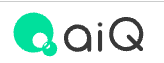

[disclaimer](../../disclaimer.txt/)

# aiQ Pos Cmsmr Goods/Elec/Retailer Evenly

本サンプルノートブックでは以下の3つのオルタナティブデータのファクターリターンをそれぞれ作成し、1/3ずつ資産配分をした合成ポートフォリオを考えます。
- aiQ POS Csmr Goods
- POS Elec Goods
- POS Retailer
それぞれのファクターリターンの相関が低いことと、合成ポートフォリオの高いパフォーマンスが確認できます。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')


In [3]:
from utils.shortcut import single_dataset as sc
from utils.shortcut import aiq_pos_retailer as scr
from utils.shortcut.path import DEFAULT_DIR

In [4]:
verbose = False

## データロード

### データハンドラーのインポート

In [5]:
from aiq_strategy_robot.data.data_accessor import DAL

In [6]:
sdh = DAL()

In [7]:
f_ticker_cvt = lambda s: f"{s[:4]}-JP"

In [8]:
scr.load_sample_dataset(sdh,  f_ticker_cvt=f_ticker_cvt)  # retailer
display(sdh.extract_definition)

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,aiq_pos_retailer,Unknown,Unknown,Unknown,"[1925-JP, 2212-JP, 2267-JP, 2651-JP, 2653-JP, ...","[ticker, datetime]",2010-04-30 00:00:00,2024-02-29 00:00:00
2,RawData,mkt,Unknown,Unknown,Unknown2,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[ticker, datetime]",2007-01-04 00:00:00,2024-06-19 00:00:00
3,RawData,finnhub,fundamental,Unknown,Unknown3,"[1925 JP, 2212 JP, 2267 JP, 2651 JP, 2653 JP, ...","[ticker, datetime]",2014-06-30 00:00:00,2024-02-29 00:00:00


In [9]:
dat_id_retail = 1

In [10]:
data_id_goods = sc.register_alt_data(sdh, data_dir=DEFAULT_DIR, f_ticker_cvt=f_ticker_cvt)
data_id_elec = sc.register_elec_data(sdh, data_dir=DEFAULT_DIR)
data_id_mkt = sc.load_finnhub_equity_data_fixed_ticker(sdh, data_dir=DEFAULT_DIR)

In [11]:
sdh.set_alias(
    {dat_id_retail: 'retail', data_id_goods: 'goods', 
     data_id_elec: 'elec', data_id_mkt: 'mkt'})

### `AltDataEvaluator`作成
セットアップしたデータハンドラーを渡し`AltDataEvaluator`を作成

In [12]:
from aiq_strategy_robot.evaluator import AltDataEvaluator, inv_return_stats, cumplot_return

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

In [13]:
sdh.transform.verbose = True

## バックテスト

In [14]:
# リターン作成
bcktest_return_id = sdh.transform.log_diff(1, data_id=data_id_mkt, fields='close').variable_ids[0]

### POS CSMR Goods weekly

In [15]:
n_shift = 6
n_rolling = 12
n_diff = 52

In [16]:
signal_goods_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_goods)
    .resample('W', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=7)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [17]:
nq = 3
exe_cost = 0.0005

dfqret_goods, stats, dfsigqt = ade.q_backtest(
    signal_goods_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

Variables being created..: process: 1, method=log_diff(periods=1): 100%|█| 1/1 [
Variables being created..: process: 11, method=shift(periods=6): 100%|█| 10/10 [


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.342844,0.023204,0.137127,0.169214,0.533241,9.176131,-0.543850,0.042666
#2,1.020372,0.069059,0.137027,0.503984,0.543364,12.555872,-0.400219,0.172553
#3,1.207877,0.081750,0.137814,0.593187,0.556664,9.256361,-0.419012,0.195101
#3-#1,0.865034,0.058546,0.049980,1.171378,0.536842,18.432492,-0.091557,0.639444
#3-#1(cost),0.728861,0.049330,0.049994,0.986706,0.532133,18.432492,-0.101039,0.488224


### POS Retailer Monthly

In [18]:
n_shift = 7
n_rolling = 2
n_diff = 12

In [19]:
signal_retailer_id = (
    sdh.transform
    .multiply('pos_sales', 'share', data_id=dat_id_retail)
    .resample('M', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=31)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)


In [20]:
nq = 3
exe_cost = 0.0005

dfqret_retailer, stats, dfsigqt = ade.q_backtest(
    signal_retailer_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

Variables being created..: process: 21, method=shift(periods=7): 100%|█| 10/10 [


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.582999,0.045674,0.138674,0.329362,0.528695,10.264397,-0.604328,0.075578
#2,1.148647,0.089988,0.143503,0.627082,0.541199,11.547610,-0.450649,0.199686
#3,1.735174,0.135939,0.145567,0.933858,0.547291,8.609486,-0.410303,0.331313
#3-#1,1.152174,0.090265,0.070118,1.287331,0.537672,18.873882,-0.126101,0.715811
#3-#1(cost),1.031718,0.080828,0.070125,1.152621,0.532222,18.873882,-0.129279,0.625219


### POS Elec Daily

In [21]:
n_shift = 4
n_rolling = 20
n_diff = 252
min_period = int(max(np.floor(n_rolling * 5 / 7), 1))

In [22]:
signal_elec_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_elec)
    .resample('D', 'last')
    .sma(n_rolling, min_period)
    .reindex(label=bcktest_return_id)
    .log_diff(n_diff)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)


In [23]:
nq = 3
exe_cost = 0.0005

dfqret_elec, stats, dfsigqt = ade.q_backtest(
    signal_elec_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

Variables being created..: process: 30, method=shift(periods=4): 100%|█| 9/9 [00


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-0.094826,-0.006715,0.204391,-0.032856,0.521437,18.501702,-0.780360,-0.008606
#2,1.158301,0.082029,0.204390,0.401338,0.542874,32.439347,-0.563791,0.145496
#3,1.143865,0.081007,0.203509,0.398051,0.544322,19.452528,-0.481842,0.168120
#3-#1,1.238691,0.087723,0.118930,0.737596,0.520857,37.954230,-0.233443,0.375777
#3-#1(cost),0.970724,0.068745,0.118947,0.577949,0.516222,37.954230,-0.253788,0.270877


## ポートフォリオ

In [24]:
elec_long_short = dfqret_elec['#3-#1'].rename('elec')
csmr_long_short = dfqret_goods['#3-#1'].rename('csmr')
retailer_long_short = dfqret_retailer['#3-#1'].rename('retailer')

elec_long_short = elec_long_short.resample('M').sum()
csmr_long_short = csmr_long_short.resample('M').sum()
retailer_long_short = retailer_long_short.resample('M').sum()

In [25]:
min_date = retailer_long_short.index.min()
max_date = elec_long_short.index.max()

In [26]:
portfolio = pd.concat([elec_long_short, csmr_long_short, retailer_long_short],axis=1)
portfolio = portfolio[portfolio.index>min_date]
portfolio = portfolio[portfolio.index<max_date]

portfolio['portfolio'] = portfolio.mean(axis=1)

In [27]:
cumplot_return(portfolio, em_pattern='portfolio')
inv_return_stats(portfolio)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,Max_DD,Calmar Ratio
elec,1.338007,0.106260,0.102500,1.036690,0.611842,-0.109120,0.973797
csmr,0.827698,0.065733,0.043064,1.526413,0.638158,-0.059443,1.105816
retailer,1.156395,0.091837,0.079386,1.156840,0.611842,-0.103809,0.884675
portfolio,1.107367,0.087944,0.044986,1.954930,0.750000,-0.031886,2.758026


# データ間相関

In [35]:
mi_names = ["ticker", "datetime"]
df_goods = dfqret_goods[["#3-#1"]]
df_goods.index = pd.MultiIndex.from_tuples([('#3-#1', dt) for dt in dfqret_goods[["#3-#1"]].index], names=mi_names)
goods_did = sdh.set_raw_data(df_goods)
goods_id = sdh.transform.raw(data_id=goods_did).variable_ids[0]

df_retailer = dfqret_retailer[["#3-#1"]]
df_retailer.index = pd.MultiIndex.from_tuples([('#3-#1', dt) for dt in dfqret_retailer[["#3-#1"]].index], names=mi_names)
retailer_did = sdh.set_raw_data(df_retailer)
retailer_id = sdh.transform.raw(data_id=retailer_did).variable_ids[0]

df_elec = dfqret_elec[["#3-#1"]]
df_elec.index = pd.MultiIndex.from_tuples([('#3-#1', dt) for dt in dfqret_elec[["#3-#1"]].index], names=mi_names)
elec_did = sdh.set_raw_data(df_elec)
elec_id = sdh.transform.raw(data_id=elec_did).variable_ids[0]

goods_id, retailer_id, elec_id

(34, 35, 36)

In [36]:
df_rho_goods_retailer = ade.compu_rho(goods_id, retailer_id, rename_features="#3-#1")
df_rho_goods_elec =     ade.compu_rho(goods_id, elec_id,     rename_features="#3-#1")
df_rho_elec_retailer =  ade.compu_rho(elec_id,  retailer_id, rename_features="#3-#1")

Variables being created..: process: 34, method=raw(): 100%|█| 1/1 [00:00<00:00, 
Variables being created..: process: 35, method=raw(): 100%|█| 1/1 [00:00<00:00, 
Variables being created..: process: 36, method=raw(): 100%|█| 1/1 [00:00<00:00, 


In [37]:
df_show = pd.concat([df_rho_goods_retailer, df_rho_goods_elec, df_rho_elec_retailer], axis=1)
df_show.columns = ["goods_retailer", "goods_elec", "elec_retailer"]
df_show

goods_retailer  goods_elec  elec_retailer
# rho          0.055652    0.038551      -0.030398
  t-val        3.111880    2.265719      -1.697934